# Learning Packet Analysis with Data Science

In [10]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

'''Use common fields in IP Packet to perform exploratory analysis on PCAP'''

'Use common fields in IP Packet to perform exploratory analysis on PCAP'

### The line below will attempt to sniff 10 packets
#### You can kill the sniffing operation with the stop button in the notebook

In [11]:
num_of_packets_to_sniff = 100
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]

<class 'scapy.plist.PacketList'>
100
<Sniffed: TCP:8 UDP:86 ICMP:0 Other:6>


<Ether  dst=ff:ff:ff:ff:ff:ff src=d0:7e:35:f2:58:f5 type=0x800 |<IP  version=4 ihl=5 tos=0x0 len=291 id=12433 flags= frag=0 ttl=128 proto=udp chksum=0xd114 src=10.25.3.244 dst=10.25.31.255 |<UDP  sport=54915 dport=54915 len=271 chksum=0x8a28 |<Raw  load="\x00LolealKlon\x00\xe1\x01\x00\x00\x10\xbaO\x99t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x003'\x00\x00\x00\x00\x00\x00\x00\x06\xd1\xc7\xe1\x01\x00\x00 \x8d\n\xc8\xe1\x01\x00\x00\xe0\xf0\xf8\xc7\xe1\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|j\xe8[\x00\x00\x00\x00\x18\xa5\x92\\\x00\x00\x00\x00I\xbeO\x99t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x90\x8a\n\xc8\xe1\x01\x00\x00\x94\xbaO\x99t\x00\x00\x00\xb0\xbaO\x99t\x00\x00\x00\x98\xbc~{4dc7224f-6b38-4298-a8c1-cd993912d3fa}\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x90\xbaO\x99t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

# Append suspicious pcap to current stream

In [12]:
# rdpcap used to Read Pcap
pcap = pcap + rdpcap("suspicious.pcap")

In [13]:
print(len(pcap))
print(pcap)

162
<Sniffed+suspicious.pcap: TCP:8 UDP:148 ICMP:0 Other:6>


# TCP Segment
#### Frames/Packets/Segments each encapsulated layer consists of fields

In [14]:
"""
0                   1                   2                   3
0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|          Source Port          |       Destination Port        |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                        Sequence Number                        |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                    Acknowledgment Number                      |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|  Data |           |U|A|P|R|S|F|                               |
| Offset| Reserved  |R|C|S|S|Y|I|            Window             |
|       |           |G|K|H|T|N|N|                               |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|           Checksum            |         Urgent Pointer        |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                    Options                    |    Padding    |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                             data                              |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
02 04 05 a0 01 03 03 05 01 01 08 0a 1d 74 65 c5 00 00 00 00 04 02 00 00
"""

# Frames/Packets/Segments all consists of fields
# TODO: Identify how to handle arrays in dataframe

print()

# Exploring an item in packet list

In [15]:
# ETHERNET -> Internet Protocol -> Layer 4 Segments
# We're only interested in Layers 3 (IP) and 4 (TCP AND UDP) 
## We'll parse those two layers and the layer 4 payload
## When capturing we capture layer 2 frames and beyond

# Retrieving a single item from packet list
ethernet_frame = pcap[101]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload # Retrieve payload that comes after layer 4

# Observe that we just popped off previous layer header
print(ethernet_frame.summary())
print(ip_packet.summary())
print(segment.summary())
print(data.summary()) # If blank, empty object

# Complete depiction of paket
## Achieving understanding that these are the fields will enable the ability 
## to ask the data more meaningful questions ie) type of layer 4 segment is defined in layer 3 packet
ethernet_frame.show()

Ether / IP / UDP / DNS Ans "2607:f8b0:4005:807::200e" 
IP / UDP / DNS Ans "2607:f8b0:4005:807::200e" 
UDP / DNS Ans "2607:f8b0:4005:807::200e" 
DNS Ans "2607:f8b0:4005:807::200e" 
###[ Ethernet ]### 
  dst       = 88:e9:fe:6a:92:52
  src       = 80:37:73:96:9b:db
  type      = 0x800
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x20
     len       = 84
     id        = 58919
     flags     = 
     frag      = 0
     ttl       = 122
     proto     = udp
     chksum    = 0x360c
     src       = 84.54.22.33
     dst       = 10.1.10.53
     \options   \
###[ UDP ]### 
        sport     = domain
        dport     = domain
        len       = 64
        chksum    = 0xfe25
###[ DNS ]### 
           id        = 12
           qr        = 1
           opcode    = QUERY
           aa        = 0
           tc        = 0
           rd        = 1
           ra        = 1
           z         = 0
           ad        = 0
           cd        = 0
           rcode     = ok
      

### Understanding object types in scapy and Importing layers

In [16]:
# Understanding the object types in scapy
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

# Packets can be filtered on layers ie) ethernet_frame[scapy.layers.l2.Ether]
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",pcap[ethernet_type])
print("IP", pcap[ip_type])
print("TCP", pcap[tcp_type])

# Scapy provides this via import statements
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])

<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.inet.IP'>
<class 'scapy.layers.inet.UDP'>
Ethernet <Ether from Sniffed+suspicious.pcap: TCP:8 UDP:148 ICMP:0 Other:6>
IP <IP from Sniffed+suspicious.pcap: TCP:2 UDP:127 ICMP:0 Other:1>
TCP <UDP from Sniffed+suspicious.pcap: TCP:0 UDP:148 ICMP:0 Other:0>
UDP <UDP from Sniffed+suspicious.pcap: TCP:0 UDP:148 ICMP:0 Other:0>


# Convert PCAP to DataFrame

In [17]:
# Collect field names from IP/TCP/UDP (These will be columns in DF)
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Create blank DataFrame
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Field array for each row of DataFrame
    field_values = []
    # Add all IP fields to dataframe
    for field in ip_fields:
        if field == 'options':
            # Retrieving number of options defined in IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Append payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

### DataFrame Basics

In [28]:
# Retrieve first row from DataFrame
print(df.iloc[0])

print(df.shape)

# Return first 5 rows
df.head()

# Return last 5 rows
df.tail()

# Return the Source Address for all rows
df['src']

# Return Src Address, Dst Address, Src Port, Dst Port
df[['src','dst','sport','dport']]

version                                                        4
ihl                                                            5
tos                                                            0
len                                                          291
id                                                         12433
flags                                                           
frag                                                           0
ttl                                                          128
proto                                                         17
chksum                                                     53524
src                                                  10.25.3.244
dst                                                 10.25.31.255
options                                                        0
time                                                 1.55028e+09
sport                                                      54915
dport                    

,src,dst,sport,dport
0,10.25.3.244,10.25.31.255,54915,54915
1,10.25.25.248,224.0.0.251,5353,5353
2,10.25.1.227,10.25.31.255,54915,54915
3,10.25.7.200,10.25.31.255,54915,54915
4,10.25.23.9,10.25.31.255,137,137
5,10.25.2.87,224.0.0.251,5353,5353
6,10.25.27.237,224.0.0.251,5353,5353
7,10.25.3.244,10.25.31.255,54915,54915
8,10.25.4.231,224.0.0.251,5353,5353
9,10.25.24.27,224.0.0.7,8001,8001


In [31]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
version,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
ihl,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
tos,0,0,0,0,0,0,0,0,0,0,...,0,32,0,32,0,32,0,32,0,32
len,291,412,291,291,78,120,448,291,394,224,...,1005,84,1017,84,1027,84,969,84,588,84
id,12433,3354,1302,13121,3777,42685,30564,12434,7884,40774,...,1,7732,1,8307,1,8744,1,9344,1,10094
flags,,,,,,,,,,DF,...,,,,,,,,,,
frag,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ttl,128,255,128,128,128,255,255,128,255,1,...,64,122,64,122,64,122,64,122,64,122
proto,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
chksum,53524,43050,65184,51856,57508,10060,15303,53523,43931,55179,...,21178,65023,21166,64448,21156,64011,21214,63411,21595,62661


# Statistics

In [19]:
# Top Source Adddress
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Destination Address
print("# Top Destination Address")
print(df['dst'].describe(),"\n\n")

frequent_address = df['src'].describe()['top']

# Who is the top address speaking to
print("# Who is Top Address Speaking to?")
print(df[df['src'] == frequent_address]['dst'].unique(),"\n\n")

# Who is the top address speaking to (dst ports)
print("# Who is the top address speaking to (Destination Ports)")
print(df[df['src'] == frequent_address]['dport'].unique(),"\n\n")

# Who is the top address speaking to (src ports)
print("# Who is the top address speaking to (Source Ports)")
print(df[df['src'] == frequent_address]['sport'].unique(),"\n\n")

# Top Source Address
count            130
unique            35
top       10.1.10.53
freq              31
Name: src, dtype: object 


# Top Destination Address
count            130
unique            13
top       10.1.10.53
freq              31
Name: dst, dtype: object 


# Who is Top Address Speaking to?
['84.54.22.33' '75.75.75.75'] 


# Who is the top address speaking to (Destination Ports)
[53] 


# Who is the top address speaking to (Source Ports)
[53 15812 23903] 




In [20]:
# Unique Source Addresses
print("Unique Source Addresses")
print(df['src'].unique())

print()

# Unique Destination Addresses
print("Unique Destination Addresses")
print(df['dst'].unique())

Unique Source Addresses
['10.25.3.244' '10.25.25.248' '10.25.1.227' '10.25.7.200' '10.25.23.9'
 '10.25.2.87' '10.25.27.237' '10.25.4.231' '10.25.24.27' '10.25.30.33'
 '10.25.16.49' '10.25.16.32' '10.25.27.177' '10.25.1.155' '10.25.27.34'
 '10.25.26.103' '0.0.0.0' '10.25.0.60' '10.25.22.233' '10.25.28.157'
 '10.25.30.37' '8.8.8.8' '10.25.1.102' '10.25.0.30' '10.25.16.126'
 '10.25.9.68' '10.25.29.172' '10.25.13.156' '10.25.14.192' '10.25.17.166'
 '10.128.128.128' '10.25.20.184' '10.1.10.53' '84.54.22.33' '75.75.75.75']

Unique Destination Addresses
['10.25.31.255' '224.0.0.251' '224.0.0.7' '10.25.27.177' '255.255.255.255'
 '8.8.8.8' '10.25.1.155' '192.176.7.62' '224.0.0.5' '224.0.0.1'
 '84.54.22.33' '10.1.10.53' '75.75.75.75']


# Graphing

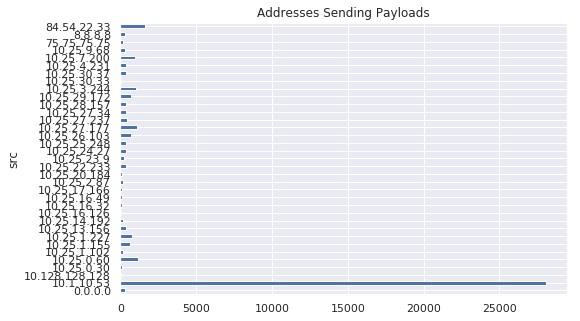

In [21]:
# Group by Source Address and Payload Sum
source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))

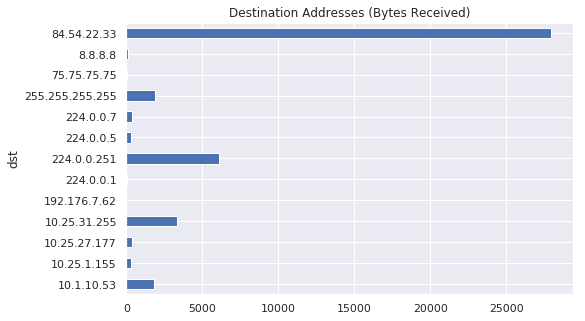

In [22]:
# Group by Destination Address and Payload Sum
destination_addresses = df.groupby("dst")['payload'].sum()
destination_addresses.plot(kind='barh', title="Destination Addresses (Bytes Received)",figsize=(8,5))

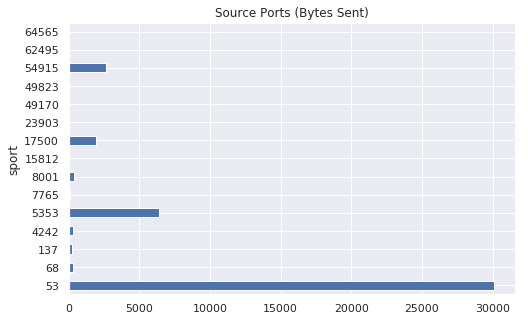

In [23]:
# Group by Source Port and Payload Sum
source_payloads = df.groupby("sport")['payload'].sum()
source_payloads.plot(kind='barh',title="Source Ports (Bytes Sent)",figsize=(8,5))

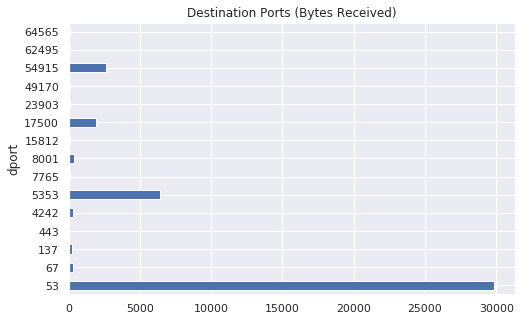

In [24]:
# Group by Destination Port and Payload Sum
destination_payloads = df.groupby("dport")['payload'].sum()
destination_payloads.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

Text(0.5, 1.0, 'History of bytes sent by most frequent address')

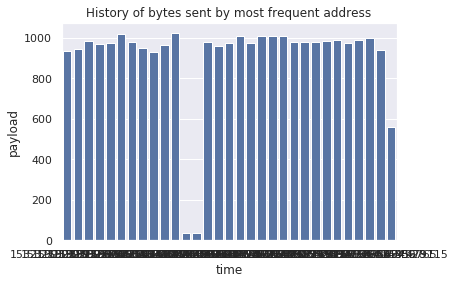

In [25]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

frequent_address_df = df[df['src'] == frequent_address]
x = frequent_address_df['payload'].tolist()
sns.barplot(x="time", y="payload", data=frequent_address_df[['payload','time']],
            label="Total", color="b").set_title("History of bytes sent by most frequent address")


# Payload Investigation

84.54.22.33 May be a suspicious address


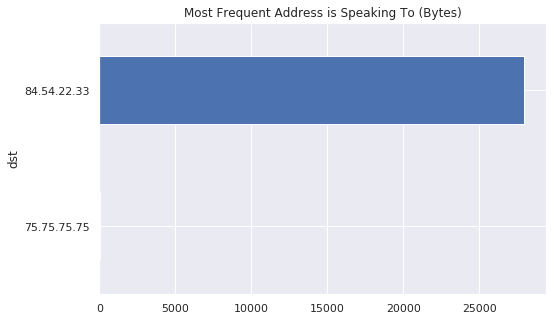

In [26]:
# Create dataframe with only converation from most frequent address
frequent_address_df = df[df['src']==frequent_address]

# Only display Src Address, Dst Address, and group by Payload 
frequent_address_groupby = frequent_address_df[['src','dst','payload']].groupby("dst")['payload'].sum()

# Plot the Frequent address is speaking to (By Payload)
frequent_address_groupby.plot(kind='barh',title="Most Frequent Address is Speaking To (Bytes)",figsize=(8,5))

# Which address has excahnged the most amount of bytes with most frequent address
suspicious_ip = frequent_address_groupby.sort_values(ascending=False).index[0]
print(suspicious_ip, "May be a suspicious address")

# Create dataframe with only conversation from most frequent address and suspicious address
suspicious_df = frequent_address_df[frequent_address_df['dst']==suspicious_ip]

In [27]:
# Store each payload in an array
raw_stream = []
for p in suspicious_df['payload_raw']:
    raw_stream.append(p)
    
print(raw_stream)

[b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xb